In [1]:
# Connect to google drive
from google.colab import drive
drive.mount('/content/drive')

project_folder = "/content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/"

Mounted at /content/drive


In [2]:
######################
## Imports
######################


import os
import numpy as np
from copy import copy
from sklearn.model_selection import train_test_split
from google.colab import drive
import random

%tensorflow_version 1.x
import tensorflow as tf
#print(tf.__version__)
#tf.reset_default_graph()
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc as smp
from tensorflow.python import debug as tf_debug
import datetime
import pandas as pd
import collections

from PIL import Image, ImageOps



TensorFlow 1.x selected.


In [ ]:
##################################
## Load data
##################################


img_path = project_folder + "data/train_test/imgs_train_test.npy"
label_path = project_folder + "data/train_test/labels_train_test.npy"
X_ = np.load(img_path)
y_ = np.load(label_path)
#those npy files should be in the folder data on gitlab/numerosity estimation project folder
# Split data in train/test sets
trX, teX, trY_labels, teY_labels = train_test_split(X_, y_, test_size=0.25, random_state=9, stratify=y_)

def one_hot(a, num_classes):
  b = copy(a)
  for i in range(a[:].size):
    b[i] = b[i] - 1 
  return np.squeeze(np.eye(num_classes)[b.reshape(-1)])

trY = one_hot(trY_labels,10)
teY = one_hot(teY_labels,10)

print (trX.shape, trY.shape, teX.shape, teY.shape)
print (trX.max(), trX.min(), teX.max(), teX.min())
print (trY_labels.max(), trY_labels.min(), teY_labels.max(), teY_labels.min())

img_size = int(np.sqrt(trX[0,:].size))
max_objects = 10

(45000, 784) (45000, 10) (15000, 784) (15000, 10)
255 0 255 0
10 1 10 1


In [ ]:
############################
## Define TensorFlow Model
############################


#from tensorflow.contrib.tensorboard.plugins import projector

n_hidden_neurons = 90


tf.reset_default_graph()

################################
## AUXILIARY FUNCTIONS
################################
def array_to_image(data):
    img = smp.toimage(np.reshape(data, (img_size,img_size)))
    return  img

def init_weights(shape, name):
    return tf.Variable(tf.random_normal(shape, stddev=0.01), name=name)
  
def conv_to_tensorboard(conv_layer, conv_name, scope_name ):
    with tf.variable_scope(scope_name):
        kernel_str = conv_name + '/kernel:0' #'/kernel/RMSProp:0' # #  #RMSProp_1:0
        kernel = tf.get_collection(tf.GraphKeys.VARIABLES, kernel_str)[0]
         # scale weights to [0 1], type is still float
        x_min = tf.reduce_min(kernel)
        x_max = tf.reduce_max(kernel)
        kernel_0_to_1 = (kernel - x_min) / (x_max - x_min)
        # to tf.image_summary format [batch_size, height, width, channels]
        kernel_transposed = tf.transpose (kernel_0_to_1, [3, 0, 1, 2])
        #kernel_transposed = tf.reshape(tf.transpose (kernel_0_to_1, [3, 0, 1, 2]), [-1,3,3,1])
        #kernel_transposed = kernel_0_to_1
        # this will display random 3 filters from the 64 in conv1
        #img = Image.fromarray(kernel_transposed.numpy()*255).resize( (100,100), resample=0).convert('RGB') 
        #('conv1_filters', img ,max_outputs=32)
        kernel_transposed = tf.image.resize(kernel_transposed, [10,10], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        #image = tf.summary.image('conv1_filters', kernel_transposed,max_outputs=32)
        
        tf.summary.image('conv2_filters', kernel_transposed,max_outputs=64)
        
def layer_and_input_activ_to_tensorboard(layer, inputt, input_id, scope_name, img_w, img_h):
    with tf.name_scope("Sizes"):
      layer_shape = layer.get_shape().as_list()
      widthy = layer.get_shape().as_list()[1]
      whole_layer = layer
    imgy = tf.reshape(layer, [-1, img_w, img_h, 1])    
    imgy2 = tf.reshape(inputt, [-1, img_size, img_size, 1])
    input_str = 'Input_' + input_id
    layer_str = scope_name + '_of_' + input_str
    tf.summary.image(input_id, imgy)
    tf.summary.image(input_id, imgy2)

    
################################
## NN - Models
################################




def conv_net(x_arr, n_classes, dropout, is_training, reuse):
    # data input might come as a 1-D vector of 784 features (28*28 pixels)
    # Reshape to match picture format [Height x Width x Channel]
    # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x_arr, shape=[-1, img_size, img_size, 1])

    # Convolution Layer with 32 filters and a kernel size of 5
    with tf.name_scope("conv1"):
      #kernel = _variable_with_weight_decay('weights', shape=[5, 5, 3, 64],
       #                                stddev=1e-4, wd=0.0)
      #conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
      #conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
      conv1 = tf.layers.conv2d(inputs=x,filters=8,kernel_size=[5, 5],padding="same",activation=tf.nn.relu, name='conv1',trainable=True)
      #conv1 = tf.layers.conv2d(inputs=x,filters=8,kernel_size=[5, 5],padding="same",activation=tf.nn.relu, name='conv1')    #original
      # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
      conv1_pool = tf.layers.max_pooling2d(conv1, 2, 2)

    # Convolution Layer with 64 filters and a kernel size of 3
    with tf.name_scope("conv2"):
      conv2 = tf.layers.conv2d(conv1_pool, 64, 3, activation=tf.nn.relu, name='conv2',trainable=True)
      #conv2 = tf.layers.conv2d(conv1, 8, 3, activation=tf.nn.relu, name='conv2')  #original
      # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
      conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

    # Flatten the data to a 1-D vector for the fully connected layer
    conv2_flatten = tf.contrib.layers.flatten(conv2)
    # Fully connected layer (in tf contrib folder for now)
    fc1 = tf.layers.dense(conv2_flatten, n_hidden_neurons)   #original 1024
    # Apply Dropout (if is_training is False, dropout is not applied)
    fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)
    fc1 = tf.sigmoid(fc1)
    

    #new_test_layer = tf.math.multiply(tf_test_layer_stacked, tf_filty_stacked)
    fc1 = tf.math.multiply(fc1, filtery)
    
    
    # Output layer, class prediction
    out = tf.nn.softmax(tf.layers.dense(fc1, n_classes))
    
    ######################
    #### PLOT LAYERS IN TENSORBOARD
    ######################
    conv_to_tensorboard(conv1, 'conv1', 'Conv1_Kernel_visualization' ) 
    #conv_to_tensorboard(conv2, 'conv2', 'Conv2_Kernel_visualization' ) 
    
    layer_shape = fc1[0].get_shape()
    widthy = fc1.get_shape().as_list()[1]
    whole_layer = fc1
    
    '''
    with tf.variable_scope('Last_layer_activation'):
      for obj in range(5):   
        layer_and_input_activ_to_tensorboard(fc1[obj:obj+1], x[obj:obj+1], str(obj), 'Last_layer_activation',3,3)
    '''
       
    with tf.variable_scope('conv1'):
      for obj in range(5):   
        layer_and_input_activ_to_tensorboard(conv1[obj:obj+1], x[obj:obj+1], str(obj), 'conv1_activation',img_size,img_size)  
    
      

       
    return out, fc1




##########################################
## CREATE QUANTITIES/PLACEHOLDERS and SET THEM INTO NN
#########################################

#Step 2 - Create input and output placeholders for data
X = tf.placeholder("float", [None, trX[0,:].size], name="X")
Y = tf.placeholder("float", [None, trY[0,:].size], name="Y")

filtery = tf.placeholder("float", [None, n_hidden_neurons], name="Y")

is_training = tf.placeholder(tf.bool)
failed_object = tf.placeholder(tf.int32, name="FAILY")
failed_object_string = tf.placeholder(dtype=tf.string)

#Step 3 - Initialize weights


#Step 5 - Add dropout to input and hidden layers
p_keep_input = tf.placeholder("float", name="p_keep_input")
p_keep_hidden = tf.placeholder("float", name="p_keep_hidden")



#Step 6 - Create Model
#py_x = fully_connected_net(X, w_h, w_h2, w_o, p_keep_input, p_keep_hidden)
py_x, fc1 = conv_net(X, trY[0,:].size, 0.25, is_training, reuse=False)




##########################################
## COST + TRAIN_STEP
#########################################
#Step 7 Create cost function
with tf.name_scope("cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=py_x,labels= Y))
    train_op = tf.train.RMSPropOptimizer(0.0005, 0.7).minimize(cost)
    # Add scalar summary for cost tensor
    tf.summary.scalar("cost", cost)

#Step 8 Measure accuracy
with tf.name_scope("accuracy"):
    correct_pred = tf.equal(tf.argmax(Y, 1), tf.argmax(py_x, 1)) # Count correct predictions
    acc_op = tf.reduce_mean(tf.cast(correct_pred, "float")) # Cast boolean to float to average
    # Add scalar summary for accuracy tensor
    tf.summary.scalar("accuracy", acc_op)
   
  
  
##########################################
## PLOT INCORRECT PREDICTIONS
#########################################
with tf.variable_scope('Failed_test_examples'):
  incorrect_pred = tf.not_equal(tf.argmax(Y, 1), tf.argmax(py_x, 1))
  indices = tf.where(incorrect_pred)
  x_arr = tf.reshape(X, shape=[-1, img_size, img_size, 1])
  x_arr_reduced = tf.gather_nd(x_arr, indices)
  imgy2 = tf.reshape(x_arr_reduced, [-1, img_size, img_size, 1])  
  to_tensi = tf.summary.image('Test', imgy2 ,max_outputs=20)


def save_and_plot_acc_cost(file_path, x_values, y_values, y_axis, x_axis='Episodes', y_values_2=None):

    matplotlib.get_backend()
    plt.plot(x_values, y_values, label='Test set')
    if(y_values_2 is not None):
       plt.plot(x_values, y_values_2, label='Train set')
       plt.legend()
    plt.ylabel(y_axis)
    plt.xlabel(x_axis)
    #plt.ylim(0,1)
    #titlestring = 'Accuracy development during learning to count up to ' + str(trY[0].size) + ' object with a CNN'
    titlestring = y_axis + ' development during learning to count up to ' + "10" + ' objects'

    img_path = file_path + "_" + y_axis + ".png"

    plt.title(titlestring)
    plt.savefig(img_path, dpi = 600)
    plt.show()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use `tf.GraphKeys.GLOBAL_VARIABLES` instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_log

In [ ]:
    
###############
##########################################
## TRAIN MODEL
## SESSION / ACTUAL RUN - keyyyy
#########################################
###############


#Step 9 Create a session
test_acc_arr = []
test_cost_arr = []
train_acc_arr = []
train_cost_arr = []
episodes = []
n_episodes = 100

final_acc = np.zeros(10)

## Create 1000 test examples for each number

mult_images = []
mult_classes = []
test_acc = []

with tf.Session() as sess:
        #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
        
        now = datetime.datetime.now()
        # Define directory name to log on.
        fily = '/' + str(now.year) + '_' + str(now.month) + '_' + str(now.day) + '_' + str(now.hour) + 'h_' + str(now.minute)
        #fily = "/simple"
        fily = './log' + fily
        #test_writer = tf.train.SummaryWriter(this_test)
        writer = tf.summary.FileWriter(fily, sess.graph) # for 0.8
        merged = tf.summary.merge_all()

        # Step 11 you need to initialize all variables
        tf.initialize_all_variables().run()
        #file_name = os.path.join(dirname, 'logs/events.out.tfevents.1539591730.NTNU15406')
        #save_model_path = '/content/drive/My Drive/Tensorflow_NumEst/saved_models/simple_model'
        result_path = "/content/drive/My Drive/Number_Estimation/Results/"
        model_id = str(random.randint(1000,10000))
        directory_name = str(model_id) + "/"
        file_name = "nn_model_" + str(model_id)
        directory_path = result_path + directory_name
        file_path = directory_path + file_name
        save_model_path = file_path

        if(not os.path.exists(directory_path) ):
              os.mkdir(directory_path)

        saver = tf.train.Saver()
        #saver.restore(sess, tf.train.latest_checkpoint(file_name))      ## if you want to get e.g. weights from a last session you can do it here!!!!!!!!
        

        
        
        #Step 12 train the  model
        for i in range(n_episodes):
            #if(i==0):
                #saver.restore(sess, './logs/Last_model')
            n_batch = 80
            batch_bool = 0
            tf_filty_stacked_2 = np.ones((128,n_hidden_neurons))
            if(batch_bool==0):
                for start, end in zip(range(0, len(trX), 128), range(128, len(trX)+1, 128)):
                    sess.run(train_op,                    feed_dict={X: trX[start:end].astype(np.float32), Y: trY[start:end].astype(np.float32),p_keep_input: 0.8, p_keep_hidden: 0.5, is_training: True, filtery:tf_filty_stacked_2})
            else:
                for b in range(int(trX[0,:].size/n_batch)):
                    batch_xs = trX[b*n_batch:b*n_batch+n_batch]
                    batch_ys = trY[b*n_batch:b*n_batch+n_batch]
                    sess.run(train_op, feed_dict={X: batch_xs, Y: batch_ys, p_keep_input: 0.8, p_keep_hidden: 0.5,is_training: True})
                    
            tf_filty_stacked_2 = np.ones((int(teX[:,0].size),n_hidden_neurons))
            indi, summary, test_acc, test_cost = sess.run([indices, merged, acc_op, cost], feed_dict={X: teX.astype(np.float32), Y: teY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0", filtery:tf_filty_stacked_2})
            tf_filty_stacked_2 = np.ones((int(trX[:,0].size),n_hidden_neurons))
            train_acc, train_cost = sess.run([acc_op, cost], feed_dict={X: trX.astype(np.float32), Y: trY.astype(np.float32),p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0", filtery:tf_filty_stacked_2})

            
          
            writer.add_summary(summary, i)  # Write summary
            print(i, test_acc)                   # Report the accuracy

            ## Append accuracies, costs and episodes
            test_acc_arr = np.append(test_acc_arr,test_acc)
            test_cost_arr = np.append(test_cost_arr,test_cost)
            train_acc_arr = np.append(train_acc_arr,train_acc)
            train_cost_arr = np.append(train_cost_arr,train_cost)
            episodes = np.append(episodes, i)



            ####################################
            ## Test for each numerosity separately and 
            ############################################
            test_acc = []
            test_acc_2 = []
            index_list = []

            if(num_list is None):
              num_list = np.unique(teY_labels)

              
            ### Test single number seperately  
            for i in num_list:

                indis = np.where(teY_labels == i)
                index_list.append(list(indis)[0] )
                teX_sub = teX[indis]
                teY_sub_labels = teY_labels[indis]
                teY_sub = one_hot(teY_sub_labels, 10)
                last_layer_activity = np.zeros( shape=(teX_sub.shape[0],n_hidden_neurons ) )
                
                if(turn_off_neurons_list_ is None and turn_on_neurons_list_ is None):
                  tf_filty_stacked_2 = np.ones((teX_sub.shape[0],n_hidden_neurons))
                else:
                  if(turn_off_neurons_list_ is not None):
                    tf_filty_stacked_2 = create_neuron_filter(teX_sub.shape[0],turn_off_neurons_list_)
                  if(turn_on_neurons_list_ is not None):
                    tf_filty_stacked_2 = create_neuron_filter_turn_on(teX_sub.shape[0],turn_on_neurons_list_)
                        
                indi, acc, last_layer_activity = sess.run([indices, acc_op, fc1], feed_dict={X: teX_sub.astype(np.float32), Y: teY_sub.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
                last_layer_activity_list.append(last_layer_activity)
                test_acc.append(acc)











        #### Check for accuracy for final model and each number 
        last_layer_activity = np.zeros( shape=(max_objects,100,n_hidden_neurons ) )
        saver.save(sess, save_model_path)    
        tf_filty_stacked_2 = np.ones((100,n_hidden_neurons))    
        ### Create 1000 test examples for each number of squares each
        #for i in range(max_objects):
        #    mult_img2, mult_class2,areas, orig_areas = Create_N_Images(100, only_one_number=True, n_squares=i+1) 
        #    mult_images.append(mult_img2)
        #    mult_classes.append(mult_class2)
            
        #    indi, summary, acc, last_layer_activity[i,:] = sess.run([indices, merged, acc_op, fc1], feed_dict={X: mult_img2.astype(np.float32), Y: mult_class2.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
        #    final_acc[i] = acc
        #test_acc.append(acc)

        ###### save and plot accuracies, costs, episodes and last layer activity
        # Accuracies and costs during training: for training and test set
        test_acc_path = file_path + "_test_accuracies"
        test_cost_path = file_path + "_test_cost"
        train_acc_path = file_path + "_train_accuracies"
        train_cost_path = file_path + "_train_cost"
        last_layer_act_path = file_path + "_last_layer_activity"
        final_acc_path = file_path + "_final_accuracy"

        np.save(test_acc_path, test_acc_arr)
        np.save(test_cost_path, test_cost_arr)
        np.save(train_acc_path, train_acc_arr)
        np.save(train_cost_path, train_cost_arr)
        np.save(last_layer_act_path, last_layer_activity)
        np.save(final_acc_path, final_acc)

        save_and_plot_acc_cost(file_path, episodes, test_acc_arr, 'Accuracy', x_axis='Episodes', y_values_2=train_acc_arr)
        save_and_plot_acc_cost(file_path, episodes, test_cost_arr, 'Loss', x_axis='Episodes', y_values_2=train_cost_arr)
        print("model_id= ", model_id)

     
    
print(test_acc)    



Instructions for updating:
Use `tf.global_variables_initializer` instead.


KeyboardInterrupt: ignored

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
#!kill 292
%tensorboard --logdir log

In [ ]:
########################
## Last layer analysis
########################


#####################
## Get last layer activity for each number
##########################

def get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_=None,turn_on_neurons_list_=None, plotty=False, num_list=None ):

    with tf.Session() as sess:

        #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
        restore_model_id = model_id
        save_model_path = project_folder + 'models/' + str(restore_model_id) + '/'
        print("model path before: ", save_model_path)
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(save_model_path))
        print("now officially restored")

        # BIAS CHANGE START: SET LAST BIAS IN LAST LAYER TO 0 to test hypothesis
        #bias = tf.get_default_graph().get_tensor_by_name('dense_1/bias:0').eval(session=sess)
        #bias_name = sess.graph.get_tensor_by_name('dense_1/bias:0')
        #bias_modified = bias
        #bias_modified[9] = 0
        #sess.run(tf.assign(bias_name, bias_modified))
        # BIAS CHANGE END

        last_layer_activity_list = []
                                         
        test_acc = []
        test_acc_2 = []
        index_list = []

        if(num_list is None):
          num_list = np.unique(teY_labels)

          
        ### Test single number seperately  
        for i in num_list:

            indis = np.where(teY_labels == i)
            index_list.append(list(indis)[0] )
            teX_sub = teX[indis]
            teY_sub_labels = teY_labels[indis]
            teY_sub = one_hot(teY_sub_labels, 10)
            last_layer_activity = np.zeros( shape=(teX_sub.shape[0],n_hidden_neurons ) )
            
            if(turn_off_neurons_list_ is None and turn_on_neurons_list_ is None):
              tf_filty_stacked_2 = np.ones((teX_sub.shape[0],n_hidden_neurons))
            else:
              if(turn_off_neurons_list_ is not None):
                tf_filty_stacked_2 = create_neuron_filter(teX_sub.shape[0],turn_off_neurons_list_)
              if(turn_on_neurons_list_ is not None):
                tf_filty_stacked_2 = create_neuron_filter_turn_on(teX_sub.shape[0],turn_on_neurons_list_)
                     
            indi, acc, last_layer_activity = sess.run([indices, acc_op, fc1], feed_dict={X: teX_sub.astype(np.float32), Y: teY_sub.astype(np.float32),filtery: tf_filty_stacked_2, p_keep_input: 1.0, p_keep_hidden: 1.0,is_training: False, failed_object: 0,failed_object_string: "0"})
            last_layer_activity_list.append(last_layer_activity)
            test_acc.append(acc)


        last_layer_activity_array_mean = activity_list_to_mean_array(last_layer_activity_list)
        
        if(plotty):
          matplotlib.get_backend()
          plt.plot(np.arange(1,max_objects+1), test_acc)
          plt.ylabel('Accuracy')
          plt.xlabel('Number of Objects')
          plt.ylim(0,1.2)
          titlestring = 'Accuracy of counting up to' + str(teY_sub[0].size) + ' objects with a CNN'
          plt.title(titlestring)
          #path_img = '/content/drive/My Drive/Number_Estimation/Tensorflow_NumEst/plots/comparison_turn_off_neurons'
          plt.legend()
          plt.show()

        return last_layer_activity_array_mean, test_acc, last_layer_activity_list, index_list

def activity_list_to_mean_array(last_layer_activity_list):
    last_layer_activity_array = np.zeros((len(last_layer_activity_list), n_hidden_neurons) )

    for i in range( len(last_layer_activity_list) ):
      last_layer_activity_i = np.mean(last_layer_activity_list[i], axis=0)
      last_layer_activity_array[i, :] = last_layer_activity_i

    return last_layer_activity_array  



####################################
## Create Neuron filters: 
## given batch_size and listy_=list of neurons to filter 
## --> numpy array (batchsize x n_hidden_neurons)
#######################################
def create_neuron_filter(batch_size, listy_, n_neurons=n_hidden_neurons):
    filty = np.ones(n_neurons)
    listy = listy_
    filty[listy] = 0

    # Stacked filter
    filty_stacked = np.zeros((batch_size,n_neurons))
    for i in range(batch_size):
      filty_stacked[i,:] = filty

    return filty_stacked 

def create_neuron_filter_turn_on(batch_size, listy_, n_neurons=n_hidden_neurons):
    filty = np.zeros(n_neurons)
    listy = listy_
    filty[listy] = 1

    # Stacked filter
    filty_stacked = np.zeros((batch_size,n_neurons))
    for i in range(batch_size):
      filty_stacked[i,:] = filty

    return filty_stacked
   


################################################
## Neuron <-> to-num-responsibility relations (vice versa)
#################################################


def get_neuron_responsibility(last_layer_activity_array, num_list=None):

    if(num_list is None):
      num_list = range(last_layer_activity_array.shape[0]+1)
    num_list_len = len(num_list)+1
    n_hidden_neurons = 90
    responsible_neurons_for_each_numerosity = []
    #fig.tight_layout()
    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)

            # Increasing tuning curves (decreasing cardinality)
            first_active = 11
            card_code = "" #later d for decreasing, i for increasing
            if(last_layer_activity_array[0,i]<0.5):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              card_code = "i"
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              card_code = "d"

            stringy = str(first_active) + card_code
            responsible_neurons_for_each_numerosity.append(stringy)


    return responsible_neurons_for_each_numerosity


def get_resp_num_for_each_neuron(last_layer_activity_array, num_list=None):

    if(num_list is None):
      num_list = range(last_layer_activity_array.shape[0]+1)
    num_list_len = len(num_list)+1
    n_hidden_neurons = 90
    num_resp_for_each_neuron = []
    #fig.tight_layout()
    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)

            # Increasing tuning curves (decreasing cardinality)
            first_active = 11
            card_code = "" #later d for decreasing, i for increasing
            if(last_layer_activity_array[0,i]<0.5):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              card_code = "i"
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              card_code = "d"

            #stringy = str(first_active) + card_code
            #responsible_neurons_for_each_numerosity.append(stringy)
            num_resp_for_each_neuron.append(first_active)


    return num_resp_for_each_neuron


def get_order_indices(resp_neuron_string):

    index_list = []
    for n in range(1,12):
      nd = str(n)+'d'
      if(nd in resp_neuron_string):
        index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == nd] 
        for i in index_sub_list:
          index_list.append(i)

    for n in range(1,12):
      ni = str(n)+'i'

      if(ni in resp_neuron_string):
        index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == ni] 
        for i in index_sub_list:
          index_list.append(i)

    return index_list






#####################
## Average data-set over: e.g. hull, area
#########################

### both the data-frame and the last layer activity should refer to the same a_h/h_a/... data-set
def extend_df_with_activities(df, last_layer_activity_array_numpy):  
    df_extended = copy(df)
    for i in range(90):  #last_layer_activity_array_numpy[0][0,:].size
        last_layer_activity_for_one_neuron = last_layer_activity_array_numpy[:,:,i]  #last_layer_activity_array_numpy[:][:,i] 
        flatten_last_layer_activity_for_one_neuron = last_layer_activity_for_one_neuron.reshape(-1)
        df_extended['activity_'+str(i)] = flatten_last_layer_activity_for_one_neuron

    return df_extended

def extend_df_with_activities_with_index(df, last_layer_activity_array_, index_list):  
    df_act = pd.DataFrame()

    big_list = index_list[0]
    for list_i in index_list[1:]:
        big_list = np.append(big_list, list_i)
    df_act['index'] = big_list


    big_list_act = last_layer_activity_array_[0]
    for list_i in last_layer_activity_array_[1:]:
        big_list_act = np.append(big_list_act, list_i, axis=0)
    for i in range(90):
        df_act['activity_' + str(i)] = big_list_act[:,i]

    df_extended = pd.merge(left=df_big, right=df_act, left_on='index', right_on='index').sort_values(by='num').reset_index()

    return df_extended


def average_activity_over(df_extended, quantity):
    df_average = pd.DataFrame()
    df_average[quantity] = df_extended[quantity].unique()
    #df_data_a_h_average = df_data_a_h_extended.groupby('num').activity_0.mean().to_frame().reset_index()
    n_neurons = 90

    for n in range(n_neurons):
      stringy = 'activity_'+str(n)
      df_average['activity_'+str(n)] = df_extended.groupby(quantity)[stringy].mean().to_frame().reset_index()[stringy]
    df_average

    return df_average

In [ ]:
###########################
## Hinton diagram
###########################

def hinton(matrix,axis=None, figy=None, input_nodes=None,input_node_description="",output_nodes=None,output_names=None, max_weight=None, ax=None, weight_encoding='size', graphy=None, input_node_names=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    #ax = ax if ax is not None else plt.gca()
    
    
    
    scale_fig=1.0
    fig_sizy=(matrix.shape[0]*scale_fig,matrix.shape[1]*scale_fig)
    fig, ax = plt.subplots(figsize=fig_sizy)
    
    if(figy is not None and axis is not None):
        fig = figy
        ax = axis
    
    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray') #gray
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    ## Extend patch to left
    text_dist = 1
    text_rect = plt.Rectangle([-7, 0], 1, 0.1, facecolor='gray', edgecolor='gray')
    ax.add_patch(text_rect)

    
    if(output_nodes is not None):
        dist_to_weights = 3
        for y in range(output_nodes.size):
            max_ampl=2 ** np.ceil(np.log(np.abs(output_nodes).max()) / np.log(2))
            color, size = get_rect_size_and_color(amplitude=output_nodes[y],max_amplitude=max_ampl,amplitude_encoding=weight_encoding, fixed_size=1)
            rect = plt.Rectangle([-dist_to_weights - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
            ax.add_patch(rect)
            if(len(str(output_names[y]))>5):
                extra_distance = 1.4
            else:
                extra_distance = 0
    if(output_names is not None):
        dist_to_weights = 3
        extra_distance = -3
        for y in range(len(output_names)):
          ax.text(-dist_to_weights-len(str(output_names[y]))/4-1.2-extra_distance, y+0.3, str(output_names[y]), fontsize=24)
            
    if(input_nodes is not None):
        dist_to_weights = 3
        for x in range(input_nodes.size):
            max_ampl=2 ** np.ceil(np.log(np.abs(input_nodes).max()) / np.log(2))
            color, size = get_rect_size_and_color(amplitude=input_nodes[x],max_amplitude=max_ampl,amplitude_encoding=weight_encoding, fixed_size=1)
            size *= 0.0001
            rect = plt.Rectangle([x - size / 2, -dist_to_weights-size/2], size, size,
                             facecolor=color, edgecolor=color)
            ax.add_patch(rect)

    
    if(input_node_names is not None):
      
      dist_to_weights = 3
      for x in range(len(input_node_names)):
        x_shift = (3-len(input_node_names[x]))/10
        ax.text(x - 1 / 2+x_shift, -dist_to_weights-0.5+2.8, str(input_node_names[x]),fontsize=24)

    for (x, y), w in np.ndenumerate(matrix):

        color, size = get_rect_size_and_color(amplitude=w,max_amplitude=max_weight,amplitude_encoding=weight_encoding, fixed_size=1)    
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)
        
    # Add "W" description
    text_dist = 1
    text_rect = plt.Rectangle([matrix.shape[0]/2-2, matrix.shape[1]+text_dist], 1, 0.1, facecolor='gray', edgecolor='gray')
    ax.add_patch(text_rect)
    ax.text(matrix.shape[0]/2-2, matrix.shape[1]+text_dist, "W", fontsize=18)
    
    # Add representation description
    text_dist = 1
    dist_to_weights = 1
    text_rect = plt.Rectangle([matrix.shape[0]/2-2, -text_dist-dist_to_weights-size-2], 1, 0.1, facecolor='gray', edgecolor='gray')
    ax.add_patch(text_rect)
    ax.text(matrix.shape[0]/2-7.0, -text_dist-dist_to_weights-size, input_node_description, fontsize=18)
        
    ax.autoscale_view()
    ax.invert_yaxis()
    #scale_fig=6
    #ax.fig_size=(x*scale_fig,y*scale_fig)
    
    return fig


def get_rect_size_and_color(amplitude,max_amplitude,amplitude_encoding='size', fixed_size=None):
        if(amplitude_encoding=='size'):
            color = 'white' if amplitude > 0 else 'black'
            size = np.sqrt(np.abs(amplitude) / max_amplitude)  #(np.abs(amplitude) / max_amplitude)        
        elif(amplitude_encoding=='transparency'):
            transparency_unclipped = (np.abs(amplitude) / max_amplitude) #(np.abs(amplitude) / max_amplitude)*(np.abs(amplitude) / max_amplitude)
            transparency = np.clip(transparency_unclipped, a_min = 0.0, a_max = 1.0) 
            if(np.isnan(transparency) or np.isinf(transparency)):
                transparency = 0.0
            if(amplitude>0):
                color = 'rgba(1,1,1,' + str(transparency) + ')'
                #color = (1,1,1,transparency)
                color = (0,0,1,transparency)
            else:
                color = 'rgba(0,0,0,' + str(transparency) + ')'
                color = (0,0,0,transparency)
                color = (1,0,0,transparency)
            size = fixed_size
        return color, size

def get_weight_matrix(model_id ):

    weights = None
    with tf.Session() as sess:

        restore_model_id = model_id
        save_model_path = '/content/drive/My Drive/Number_Estimation/Results/' + str(restore_model_id) + '/'
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(save_model_path))

        graph = tf.get_default_graph()

        #for i, var in enumerate(saver._var_list):
        #    print('Var {}: {}'.format(i, var))

        weights = tf.get_default_graph().get_tensor_by_name('dense_1/kernel:0').eval()
        bias = tf.get_default_graph().get_tensor_by_name('dense_1/bias:0').eval()

    return weights, bias

In [ ]:
with tf.Session() as sess:

    #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
    restore_model_id = model_id
    save_model_path = project_folder + 'models/' + str(restore_model_id) + '/'
    print("model path before: ", save_model_path)
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(save_model_path))

for i, var in enumerate(saver._var_list):
    print('Var {}: {}'.format(i, var))

NameError: ignored

In [ ]:
# biaskey

with tf.Session() as sess:

    #sess = tf_debug.TensorBoardDebugWrapperSession(sess, "localhost:6064")
    restore_model_id = model_id
    save_model_path = project_folder + 'models/' + str(restore_model_id) + '/'
    print("model path before: ", save_model_path)
    saver = tf.train.Saver()
    saver.restore(sess, tf.train.latest_checkpoint(save_model_path))
    bias = tf.get_default_graph().get_tensor_by_name('dense_1/bias:0').eval(session=sess)
    print(bias)
    bias_name = sess.graph.get_tensor_by_name('dense_1/bias:0')
    print(sess.run(bias_name))   # 1.0
    bias_modified = bias
    bias_modified[9] = 0
    sess.run(tf.assign(bias_name, bias_modified))
    print(sess.run(bias_name))   # 2.0

model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
[ 0.13458018  0.1013922  -0.3097277   0.06444771 -0.09014393 -0.09648186
 -0.5535365  -0.41968843 -0.05313485  0.25160348]
[ 0.13458018  0.1013922  -0.3097277   0.06444771 -0.09014393 -0.09648186
 -0.5535365  -0.41968843 -0.05313485  0.25160348]
[ 0.13458018  0.1013922  -0.3097277   0.06444771 -0.09014393 -0.09648186
 -0.5535365  -0.41968843 -0.05313485  0.        ]


In [ ]:
#########################################
## Plotting functions
##########################################


################################
## Plot last layer activity: plain=over numerosities(ordered/unordered), over areas/hull(ordered/unordered)
def plot_last_layer_activity(last_layer_activity_array, num_list=None, img_path=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    if(num_list is None):
      num_list = range(last_layer_activity_array.shape[0])
    num_list_len = len(num_list)
    responsible_neurons_for_each_numerosity = [[] for _ in range(num_list_len)]
    #fig.tight_layout()

    neural_activity_incr = [0]*num_list_len
    neural_activity_decr = [0]*num_list_len

    first_active_incr_already = [False]*11
    first_active_decr_already = [False]*11

    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)
            ax[int(i/10), i%10].set_title(title_string)
            #ax[int(i/10), i%10].plot(range(5), range(5) )
            ax[int(i/10), i%10].plot(num_list, last_layer_activity_array[:,i], 'o' )


            # Increasing tuning curves (decreasing cardinality)
            first_active = 10
            if(last_layer_activity_array[0,i]<0.1):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              if(first_active_incr_already[first_active]==False):
                neural_activity_incr[first_active-1] = last_layer_activity_array[:,i]
                first_active_incr_already[first_active]=True
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              if(first_active_decr_already[first_active]==False):
                neural_activity_decr[first_active-1] = last_layer_activity_array[:,i]
                first_active_decr_already[first_active]=True
                print("Decreasing neuron: ", i)

            ax[int(i/10), i%10].text(4,0.5,str(first_active), color='red')

            responsible_neurons_for_each_numerosity[first_active-1].append(i)
            #ax[int(i/10), i%10].set_xticks(self, ticks, minor=False)

    for n in range(num_list_len):
      stringy = "Responsible units for N= " + str(n+1) + ": " + str(responsible_neurons_for_each_numerosity[n])
      print(stringy)
    plt.subplots_adjust()
    print("test_acc: ", test_acc)
    if(img_path is not None):
      fig.savefig(img_path)

    return responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr





def plot_last_layer_activity_ordered(last_layer_activity_array, num_list=None, index_list=None, img_path=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    if(num_list is None):
      num_list = range(1,last_layer_activity_array.shape[0]+1)
    num_list_len = len(num_list)
    responsible_neurons_for_each_numerosity = [[] for _ in range(num_list_len+1)]
    #fig.tight_layout()

    neural_activity_incr = [0]*(num_list_len+1)
    neural_activity_decr = [0]*(num_list_len+1)

    first_active_incr_already = [False]*12
    first_active_decr_already = [False]*12

    # axes are in a two-dimensional array, indexed by [row, col]
    j = 0
    for i in index_list:

            #ax[int(i/10), i%10].plot(range(5), range(5) )
            ax[int(j/10), j%10].plot(num_list, last_layer_activity_array[:,i], 'o' )


            # Increasing tuning curves (decreasing cardinality)
            first_active = 11
            if(last_layer_activity_array[0,i]<0.5):
              was_active = False
              
              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] > 0.5 and was_active==False):
                      first_active = k+1
                      was_active = True
              if(first_active_incr_already[first_active]==False):
                neural_activity_incr[first_active-1] = last_layer_activity_array[:,i]
                first_active_incr_already[first_active]=True
            else:
              was_active = False

              for k in range(1,last_layer_activity_array[:,i].size):
                  if(last_layer_activity_array[k,i] < 0.5 and was_active==False):
                      first_active = k
                      was_active = True
              if(first_active_decr_already[first_active]==False):
                neural_activity_decr[first_active-1] = last_layer_activity_array[:,i]
                first_active_decr_already[first_active]=True
                print("Decreasing neuron: ", i)

            #ax[int(j/10), j%10].text(4,0.5,str(first_active), color='red')
            first_active_string = str(first_active)
            if(first_active==11):
              first_active_string='-'
            title_string = 'N=' + str(j) + '        ' + first_active_string
            ax[int(j/10), j%10].set_title(title_string, fontsize=14)
            ax[int(j/10), j%10].tick_params(axis="y", labelsize=14)
            ax[int(j/10), j%10].set_yticks([0.0,0.5,1.0])
            
            if(int(j/10)==8):
              ax[int(j/10), j%10].set_xticks([1,5,10])
              ax[int(j/10), j%10].tick_params(axis="x", labelsize=14)

            responsible_neurons_for_each_numerosity[first_active-1].append(i)
            j += 1
            #ax[int(i/10), i%10].set_xticks(self, ticks, minor=False)

    for n in range(num_list_len):
      stringy = "Responsible units for N= " + str(n+1) + ": " + str(responsible_neurons_for_each_numerosity[n])
      print(stringy)
    plt.subplots_adjust()
    plt.tight_layout()
    print("test_acc: ", test_acc)
    if(img_path is not None):
      fig.savefig(img_path)

    return responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr

def plot_last_layer_activity_areas(df_average, quantity, num_list=None, img_path=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    x_range = df_average['activity_'+str(0)][:].size

    if(quantity=='num'):
        responsible_neurons_for_each_numerosity = [[] for _ in range(x_range)]
    else:
        responsible_neurons_for_each_numerosity = []

    # axes are in a two-dimensional array, indexed by [row, col]
    for i in range(n_hidden_neurons):
            title_string = 'N= ' + str(i)
            ax[int(i/10), i%10].set_title(title_string, fontsize=14)
            ax[int(i/10), i%10].plot(df_average[quantity].values, df_average['activity_'+str(i)], 'o' )

            if(quantity=='num'):
                  # Increasing tuning curves (decreasing cardinality)
                  if(df_average['activity_'+str(i)][0]<0.1):
                    was_active = False
                    first_active = 1
                    for k in range(1,x_range):
                        if(df_average['activity_'+str(i)][k] > 0.5 and was_active==False):
                            first_active = k+1
                            was_active = True
                  else:
                    was_active = False
                    first_active = 1
                    for k in range(1,x_range):
                        if(df_average['activity_'+str(i)][k] < 0.5 and was_active==False):
                            first_active = k
                            was_active = True

                  ax[int(i/10), i%10].text(4,0.5,str(first_active), color='red')

                  responsible_neurons_for_each_numerosity[first_active-1].append(i)
                  #ax[int(i/10), i%10].set_xticks(self, ticks, minor=False)
    if(quantity=='num'):
        for n in range(x_range):
            stringy = "Responsible units for N= " + str(n+1) + ": " + str(responsible_neurons_for_each_numerosity[n])
            print(stringy)
        plt.subplots_adjust()

    plt.subplots_adjust()

    if(img_path is not None):
      fig.savefig(img_path)

    return responsible_neurons_for_each_numerosity

def plot_last_layer_activity_areas_ordered(df_average, quantity, num_list=None, index_list=None, num_resp_for_each_neuron=None, img_path=None):
    fig, ax = plt.subplots(9, 10, sharex='col', sharey='row', figsize=(15,15))

    x_range = df_average['activity_'+str(0)][:].size
    num_resps = num_resp_for_each_neuron
    # axes are in a two-dimensional array, indexed by [row, col]
    j = 0
    for i in index_list:

            ax[int(j/10), j%10].plot(df_average[quantity].values, df_average['activity_'+str(i)], 'o' )      
            num_resp_string = str(num_resps[i])
            if(num_resps[i]==11):
              num_resp_string = '-'
            title_string = 'N=' + str(j) + '        ' + num_resp_string
            ax[int(j/10), j%10].set_title(title_string, fontsize=14)
            ax[int(j/10), j%10].tick_params(axis="y", labelsize=14)
            if(int(j/10)==8):
              min_max = [min(df_average[quantity].values),max(df_average[quantity].values)]
              ax[int(j/10), j%10].set_xticks(min_max)
              #ax[int(j/10), j%10].set_xticks([1,5,10])
              ax[int(j/10), j%10].tick_params(axis="x", labelsize=14)
              
            j += 1

    plt.subplots_adjust()
    plt.tight_layout()

    if(img_path is not None):
      fig.savefig(img_path)






In [ ]:
#################################
## Plot accuracies with filtered neurons in last layer
#######################################

def plot_positive_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    test_acc_for_each_filtered_num = []

    for i in range(max_objects):
        n=i
        turn_on_neurons_list = responsible_neurons_for_each_numerosity[n]
        last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_on_neurons_list_ = turn_on_neurons_list, plotty=False)

        matplotlib.get_backend()
        ax[i].plot(np.arange(1,len(test_acc)+1), test_acc)
        ax[i].set_ylim(0.0, 1.1)

        test_acc_for_each_filtered_num.append(test_acc)

    return test_acc_for_each_filtered_num

def plot_accuracy_from_existing_test_acc(test_acc_for_each_filtered_num):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    for i in range(len(test_acc_for_each_filtered_num)):

        test_acc = test_acc_for_each_filtered_num[i]
        matplotlib.get_backend()
        ax[i].plot(np.arange(1,len(test_acc)+1), test_acc)
        ax[i].set_ylim(0.0, 1.1)


def plot_negative_accuracy(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    test_acc_for_each_filtered_num = []

    for i in range(max_objects):
        n=i
        turn_off_neurons_list = responsible_neurons_for_each_numerosity[n]
        last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_ = turn_off_neurons_list, plotty=False)

        matplotlib.get_backend()
        ax[i].plot(np.arange(1,max_objects+1), test_acc)
        ax[i].set_ylim(0.0, 1.1)
        ax[i].set_xticks(range(1,11))

        test_acc_for_each_filtered_num.append(test_acc)

    return test_acc_for_each_filtered_num


def plot_negative_accuracy_two_rows(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels, img_path=None):
    fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(18,8))


    for i in range(10):
      turn_off_neurons_list = responsible_neurons_for_each_numerosity[i]
      last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_ = turn_off_neurons_list, plotty=False)
      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc)
      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc, 'o', color='black')
      ax[int(i/5), i%5].set_ylim(-0.1, 1.1)
      ax[int(i/5), i%5].set_xticks(range(1,11))  
      ax[int(i/5), i%5].set_xlabel('Number of Objects', fontsize=16)
      ax[int(i/5), i%5].tick_params(axis="x", labelsize=16)
      ax[int(i/5), i%5].tick_params(axis="y", labelsize=16)

      if(i%5==0):
        ax[int(i/5), i%5].set_ylabel('Accuracy', fontsize=16)
    fig.tight_layout()

    if(img_path is not None):
      fig.savefig(img_path)

def plot_positive_accuracy_two_rows(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels, img_path=None):
    fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(18,8))


    for i in range(10):
      turn_on_neurons_list = responsible_neurons_for_each_numerosity[i]
      last_layer_activity_array_, test_acc, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_on_neurons_list_ = turn_on_neurons_list, plotty=False)

      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc)
      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc, 'o', color='black')
      ax[int(i/5), i%5].set_ylim(-0.1, 1.1)
      ax[int(i/5), i%5].set_xticks(range(1,11))  
      ax[int(i/5), i%5].set_xlabel('Number of Objects', fontsize=14)

      if(i%5==0):
        ax[int(i/5), i%5].set_ylabel('Accuracy', fontsize=14)
    fig.tight_layout()

    if(img_path is not None):
      fig.savefig(img_path)

def plot_accuracy_from_existing_test_acc(test_acc_for_each_filtered_num):
    fig, ax = plt.subplots(1, max_objects, figsize=(40,3))

    for i in range(len(test_acc_for_each_filtered_num)):

        test_acc = test_acc_for_each_filtered_num[i]
        matplotlib.get_backend()
        ax[i].plot(np.arange(1,len(test_acc)+1), test_acc)
        ax[i].set_ylim(-0.1, 1.1)


def plot_accuracy_from_existing_test_acc_two_rows(test_acc_for_each_filtered_num, img_path=None):
    fig, ax = plt.subplots(2, 5, sharex='col', sharey='row', figsize=(18,8))

    for i in range(len(test_acc_for_each_filtered_num)):

      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc_for_each_filtered_num[i])
      ax[int(i/5), i%5].plot(np.arange(1,max_objects+1), test_acc_for_each_filtered_num[i], 'o', color='black')
      ax[int(i/5), i%5].set_ylim(-0.1, 1.1)
      ax[int(i/5), i%5].set_xticks(range(1,11))  
      ax[int(i/5), i%5].set_xlabel('Number of Objects', fontsize=14)

      if(i%5==0):
        ax[int(i/5), i%5].set_ylabel('Activity', fontsize=14)
    fig.tight_layout()
    if(len(test_acc_for_each_filtered_num)<10):
      fig.delaxes(ax[1,4])

    if(img_path is not None):
      fig.savefig(img_path)


def test_act_dict_to_array(neural_activity):
    neural_activity_list = []

    neural_activity_incr_ordered = collections.OrderedDict(sorted(neural_activity.items()))
    for i in neural_activity_incr_ordered.values():
      neural_activity_list.append(i)

    neural_activity_array = np.asarray(neural_activity_list)
    #print(neural_activity_array.shape)
    return neural_activity_array



In [ ]:
####################
###########################
#### RUN
###########################
####################

In [ ]:
# Load training set:
df_train = pd.read_csv(project_folder + "/data/train_test/data_train_test.csv")

# And for analysis big data set:
# Load big data set: 100.000 images used to do the analysis in the paper
df_big = pd.read_csv(project_folder + 'data/test_neural/data_100000.csv')
df_imgs_big = np.load(project_folder + 'data/test_neural/imgs_100000.npy')
df_big_labels = df_big.num.values

In [ ]:
# Train


In [ ]:
# Get last layer activity
model_id = 2282 #paper
#model_id = 7205
last_layer_activity_array, test_acc, last_layer_activity_list, indy_list  = get_last_layer_activity_for_each_number(model_id, df_imgs_big, df_big_labels, plotty=False)
last_layer_activity_array_numpy = np.asarray(last_layer_activity_list)

model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
now officially restored


In [ ]:
print(test_acc)

[1.0, 0.99990064, 0.9999, 0.99901175, 0.9983807, 0.9970417, 0.9975935, 0.9982116, 0.9974892, 0.99445283]


In [ ]:
# Get numersoity <-> responsible neurons relations: both directions
resp_neuron_string = get_neuron_responsibility(last_layer_activity_array)
num_resp_for_each_neuron = get_resp_num_for_each_neuron(last_layer_activity_array)

# Order neurons: get index_list for ordering
index_list = get_order_indices(resp_neuron_string)

print("resp_neuron_string: ", resp_neuron_string)
print("num_resp_for_each_neuron: ", num_resp_for_each_neuron)
print("index_list: ", index_list)

resp_neuron_string:  ['11i', '9i', '5d', '11d', '7i', '3i', '1d', '3d', '1d', '2d', '8d', '2d', '3i', '4d', '4d', '2i', '2i', '4i', '6i', '9d', '6i', '11i', '3i', '5i', '5i', '2d', '3i', '5i', '11i', '3d', '11i', '4d', '1d', '2i', '1d', '5d', '1d', '2i', '6i', '4i', '5i', '7i', '1d', '11d', '3d', '4d', '4i', '2d', '8i', '2i', '1d', '2d', '5d', '4d', '11d', '5d', '4i', '1d', '3d', '3i', '4d', '11d', '3d', '3i', '6d', '7d', '11d', '2i', '6i', '2i', '7d', '8d', '11i', '3d', '6d', '3i', '5i', '5i', '11i', '10i', '11i', '11i', '3d', '5i', '7i', '3d', '11i', '7d', '8d', '9d']
num_resp_for_each_neuron:  [11, 9, 5, 11, 7, 3, 1, 3, 1, 2, 8, 2, 3, 4, 4, 2, 2, 4, 6, 9, 6, 11, 3, 5, 5, 2, 3, 5, 11, 3, 11, 4, 1, 2, 1, 5, 1, 2, 6, 4, 5, 7, 1, 11, 3, 4, 4, 2, 8, 2, 1, 2, 5, 4, 11, 5, 4, 1, 3, 3, 4, 11, 3, 3, 6, 7, 11, 2, 6, 2, 7, 8, 11, 3, 6, 3, 5, 5, 11, 10, 11, 11, 3, 5, 7, 3, 11, 7, 8, 9]
index_list:  [6, 8, 32, 34, 36, 42, 50, 57, 9, 11, 25, 47, 51, 7, 29, 44, 58, 62, 73, 82, 85, 13, 14, 31, 45, 

Decreasing neuron:  6
Decreasing neuron:  9
Decreasing neuron:  7
Decreasing neuron:  13
Decreasing neuron:  2
Decreasing neuron:  64
Decreasing neuron:  65
Decreasing neuron:  10
Decreasing neuron:  19
Decreasing neuron:  3
Responsible units for N= 1: [6, 8, 32, 34, 36, 42, 50, 57]
Responsible units for N= 2: [9, 11, 25, 47, 51, 15, 16, 33, 37, 49, 67, 69]
Responsible units for N= 3: [7, 29, 44, 58, 62, 73, 82, 85, 5, 12, 22, 26, 59, 63, 75]
Responsible units for N= 4: [13, 14, 31, 45, 53, 60, 17, 39, 46, 56]
Responsible units for N= 5: [2, 35, 52, 55, 23, 24, 27, 40, 76, 77, 83]
Responsible units for N= 6: [64, 74, 18, 20, 38, 68]
Responsible units for N= 7: [65, 70, 87, 4, 41, 84]
Responsible units for N= 8: [10, 71, 88, 48]
Responsible units for N= 9: [19, 89, 1]
Responsible units for N= 10: [79]
test_acc:  [1.0, 0.99990064, 0.9999, 0.99901175, 0.9983807, 0.9970417, 0.9975935, 0.9982116, 0.9974892, 0.99445283]


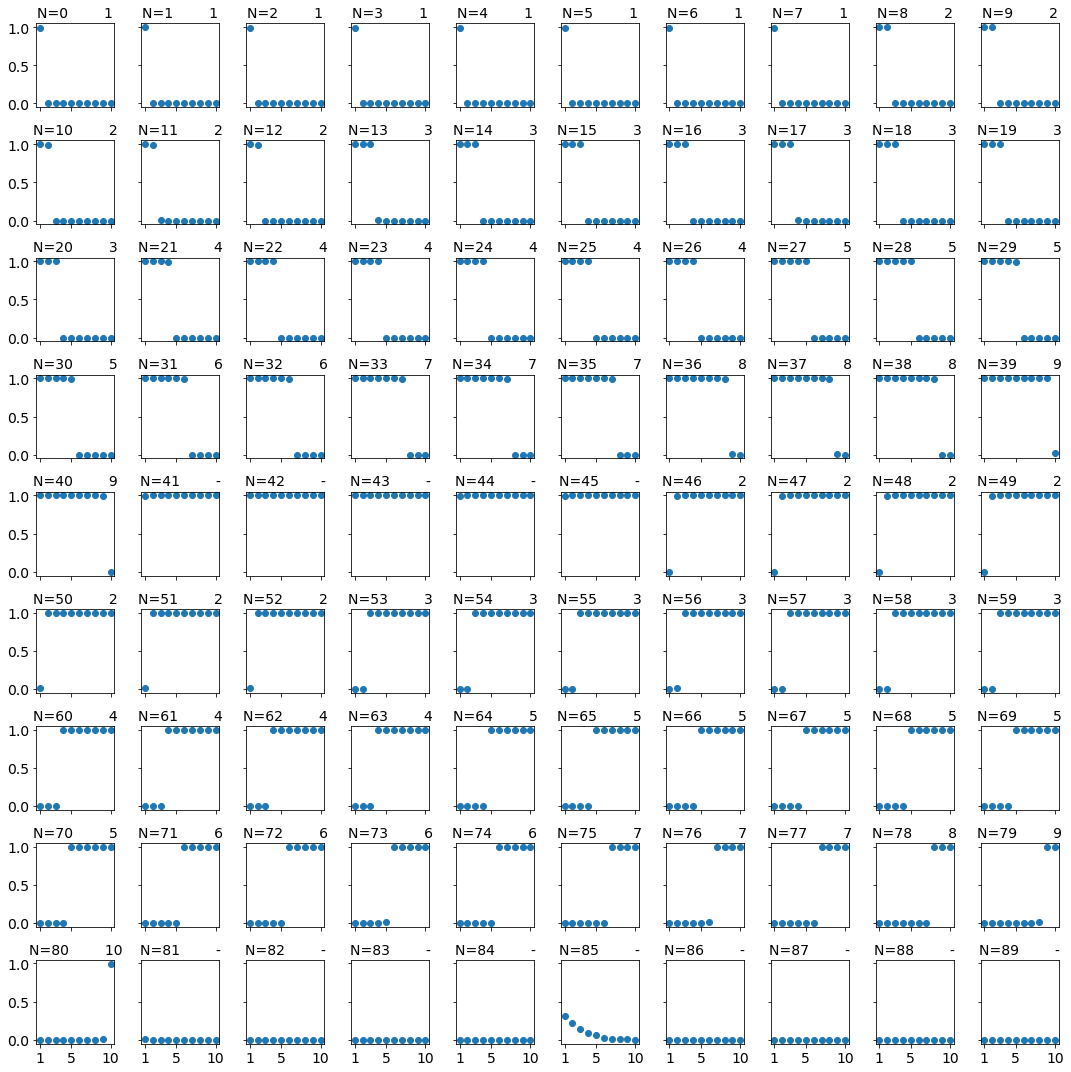

In [ ]:
# Plot ordered last layer activity: tuning curves over numerosities
img_path = project_folder + 'results/df_big_activity_over_num.svg'
responsible_neurons_for_each_numerosity, neural_activity_incr, neural_activity_decr = plot_last_layer_activity_ordered(last_layer_activity_array, index_list=index_list, img_path=img_path)

In [ ]:
print(responsible_neurons_for_each_numerosity)
print(len(responsible_neurons_for_each_numerosity))
for i in range(len(responsible_neurons_for_each_numerosity)):
  print(str(i+1), ":", len(responsible_neurons_for_each_numerosity[i]))

[[6, 8, 32, 34, 36, 42, 50, 57, 72], [9, 11, 25, 47, 51, 15, 16, 33, 37, 49, 67, 69], [7, 29, 44, 58, 62, 73, 82, 85, 5, 12, 22, 26, 59, 63, 75], [13, 14, 31, 45, 53, 60, 17, 39, 46, 56], [2, 35, 52, 55, 23, 24, 27, 40, 76, 77, 83], [64, 74, 18, 20, 38, 68], [65, 70, 87, 4, 41, 84], [10, 71, 88, 48], [19, 89, 1], [3, 43, 54, 61, 66, 0, 21, 28, 30, 78, 79, 80, 81, 86]]
10
1 : 9
2 : 12
3 : 15
4 : 10
5 : 11
6 : 6
7 : 6
8 : 4
9 : 3
10 : 14


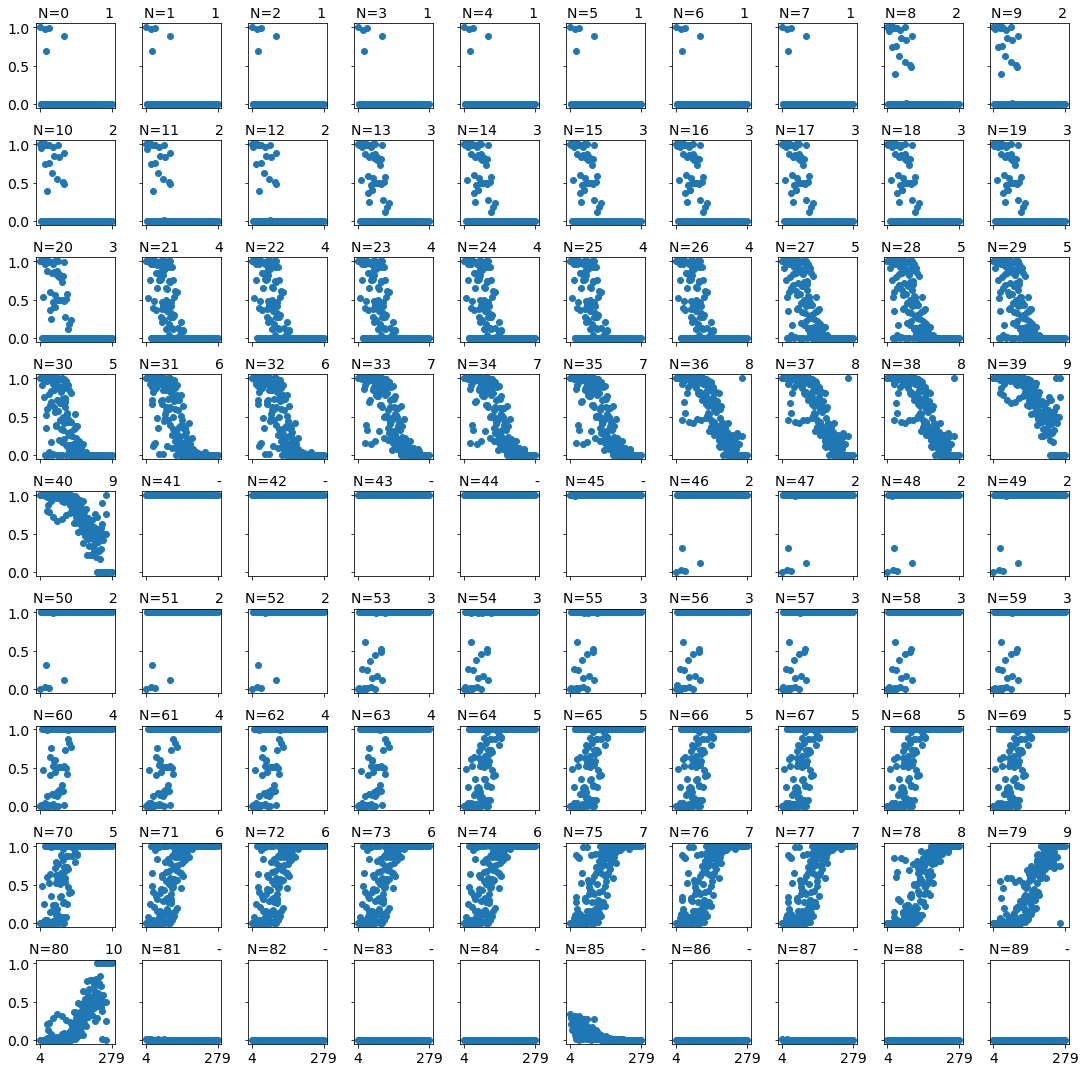

In [ ]:
# Plot tuning curves over area and hull
df_extended = extend_df_with_activities_with_index(df_big, last_layer_activity_array_numpy, index_list=indy_list)

quantity = 'area'
df_average = average_activity_over(df_extended, quantity)
img_path = project_folder + 'results/df_big_activity_over_area.png'
plot_last_layer_activity_areas_ordered(df_average, quantity, num_list=None, index_list=index_list, num_resp_for_each_neuron=num_resp_for_each_neuron, img_path=img_path)


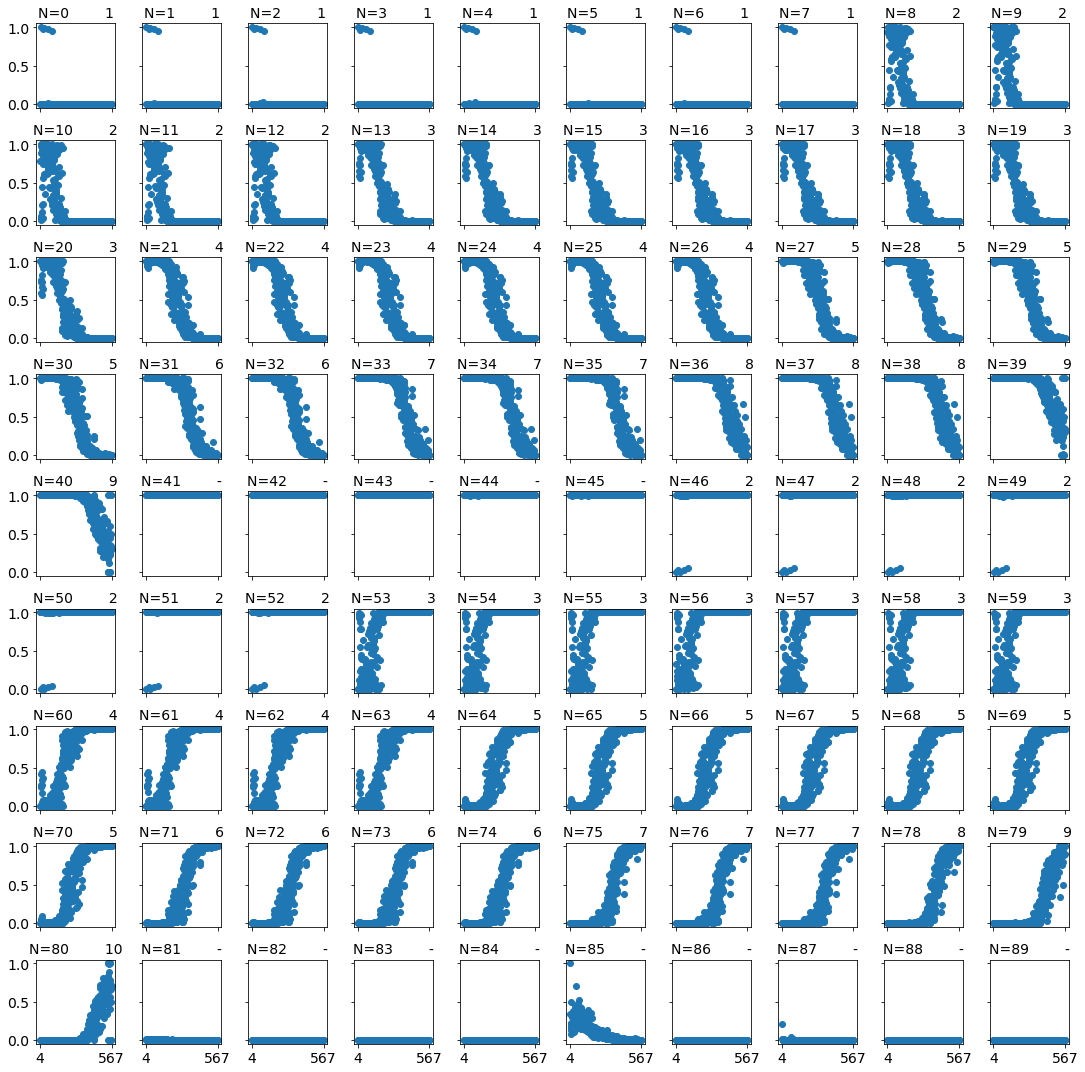

In [ ]:
quantity = 'hull'
df_average = average_activity_over(df_extended, quantity)

img_path = project_folder + 'results/df_big_activity_over_hull.svg'
plot_last_layer_activity_areas_ordered(df_average, quantity, num_list=None, index_list=index_list, num_resp_for_each_neuron=num_resp_for_each_neuron, img_path=img_path)

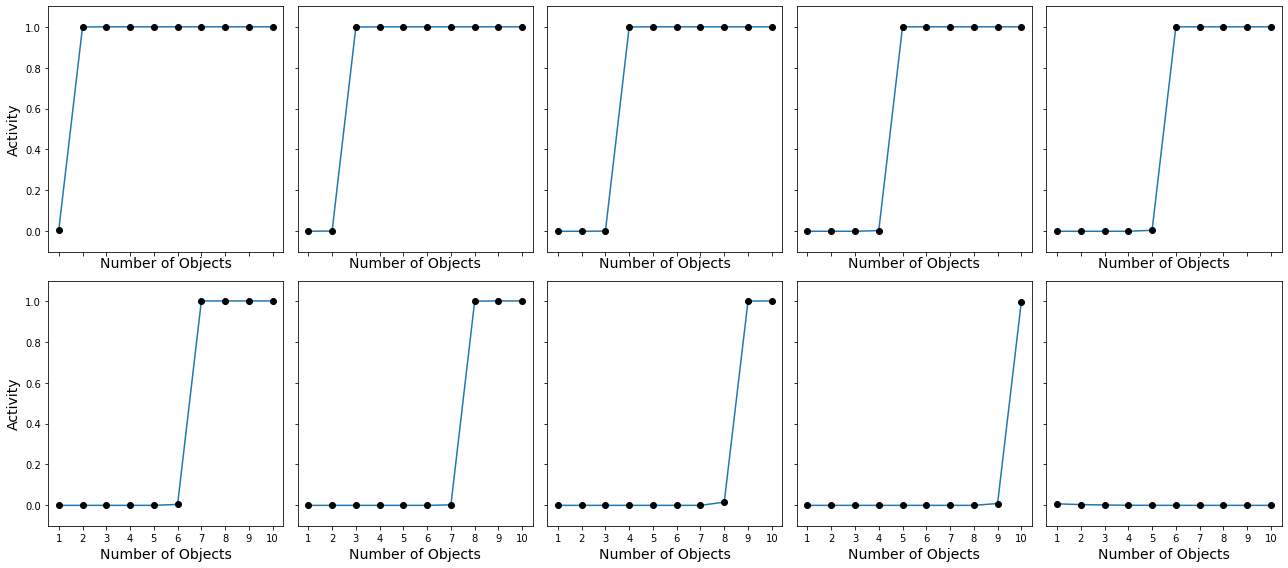

In [ ]:
# Plot 1 tuning curve for each cardinality: increasing and decreasing
#neural_activity_incr_array = test_act_dict_to_array(neural_activity_incr)
#neural_activity_decr_array = test_act_dict_to_array(neural_activity_decr)
#print(neural_activity_decr_array)
img_path = project_folder + 'results/increasing_tuning_curves.png'
#img_path=None
plot_accuracy_from_existing_test_acc_two_rows(neural_activity_incr[1:], img_path)

img_path = project_folder + 'results/decreasing_tuning_curves.png'
img_path=None
#plot_accuracy_from_existing_test_acc_two_rows(neural_activity_decr, img_path)

model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
now officially restored
model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
now officially restored
model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
now officially restored
model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
now officially restored
model path before:  /con

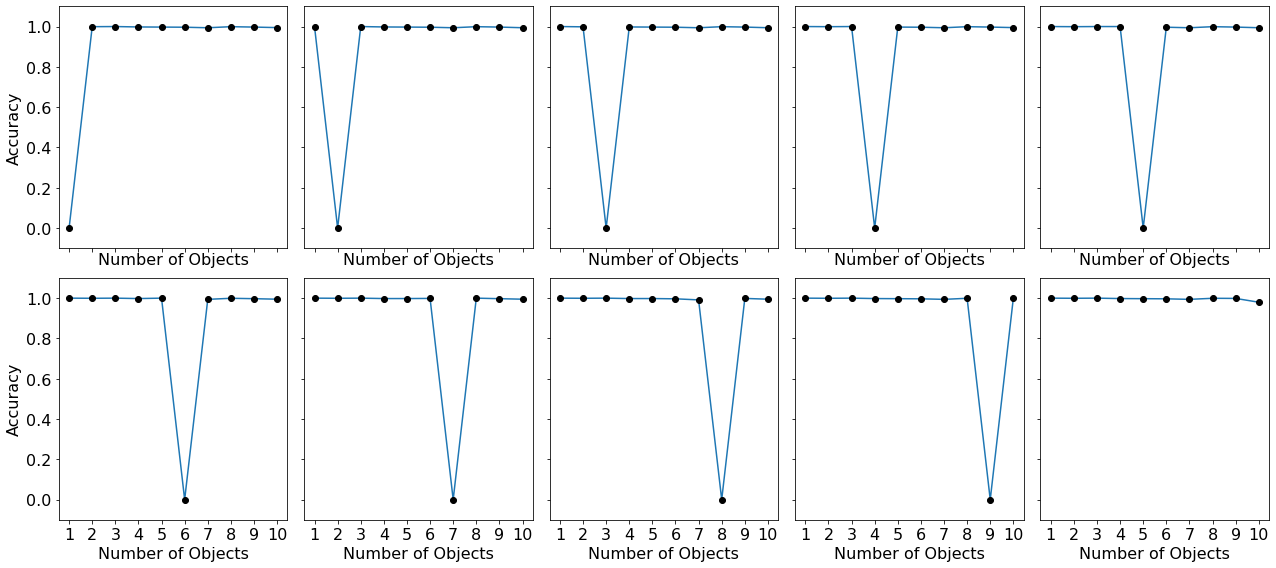

In [ ]:
# Plot accuracy of network with filtered last layer (according to responsible neurons)
img_path = project_folder + 'results/positive_accuracies.svg'
#plot_positive_accuracy_two_rows(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels, img_path=img_path)

img_path = project_folder + 'results/negative_accuracies.png'
plot_negative_accuracy_two_rows(responsible_neurons_for_each_numerosity, model_id, teX, teY_labels, img_path=img_path)

model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
now officially restored


No handles with labels found to put in legend.


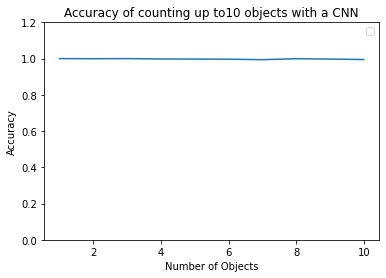

In [ ]:
turn_off_neurons_list = [3, 43, 54, 61, 66, 0, 21, 28, 30, 78, 79, 80, 81, 86]
turn_off_neurons_list = [6, 8, 32, 34, 36, 42, 50, 57, 72]
turn_off_neurons_list = [3, 43, 54, 61, 66, 0, 21, 28, 30, 78, 79, 80, 81, 86,6, 8, 32, 34, 36, 42, 50, 57, 72,19, 89, 1]
turn_off_neurons_list = [86]
last_layer_activity_array_, _, _, _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_off_neurons_list_ = turn_off_neurons_list, plotty=True)

In [ ]:
## Find your neurons you want to filter:

nd = '2i'
index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == nd] 
print(index_sub_list)

nd = '5d'
index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == nd] 
print(index_sub_list)

[15, 16, 33, 37, 49, 67, 69]
[2, 35, 52, 55]


In [ ]:
index_sub_list = [i for i, value in enumerate(resp_neuron_string) if value == '10'] 

model path before:  /content/drive/My Drive/Number_Estimation/numerosity-estimation-master-data/models/2282/
INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
now officially restored


No handles with labels found to put in legend.


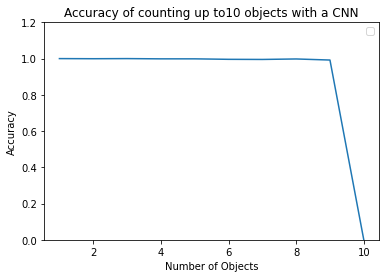

In [ ]:
turn_on_neurons_list =  [15, 16, 33, 37, 49, 67, 69]#
turn_on_neurons_list =  [9, 11, 25, 47, 51]
#turn_on_neurons_list = 
turn_on_neurons_list = [i for i, value in enumerate(resp_neuron_string) if 'd' in value] 
last_layer_activity_array_, _ , _ , _ = get_last_layer_activity_for_each_number(model_id, teX, teY_labels, turn_on_neurons_list_ = turn_on_neurons_list, plotty=True)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Number_Estimation/Results/2282/nn_model_2282
None


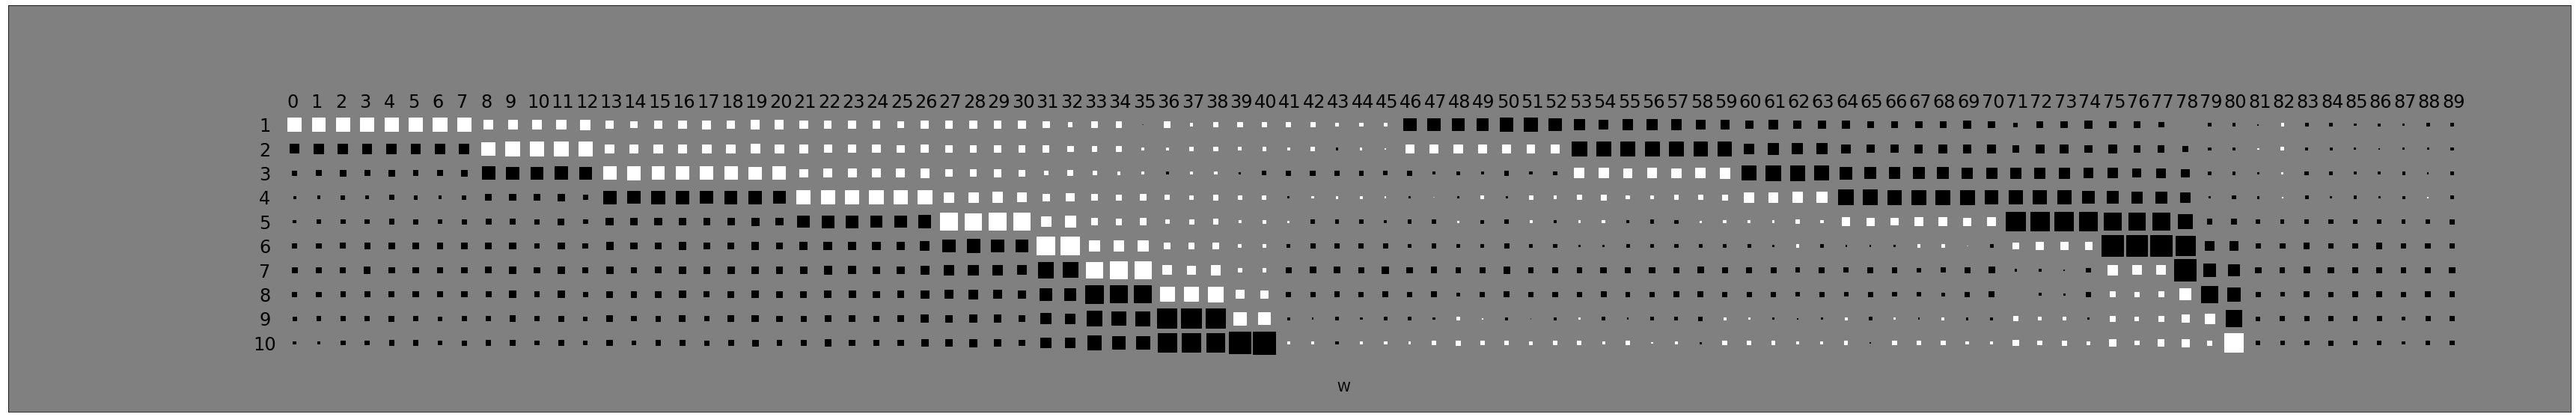

In [ ]:
# Plot hinton diagram

weights, bias = get_weight_matrix(2282)  

sorted_weights = weights[index_list,:]
input_nodes = np.ones(90)
output_nodes = None #np.ones(10) #bias
weight_matrix = np.ones((20,10))


one_to_ten_string = [str(i) for i in range(1,11)]
zero_to_ninty_string = [str(i) for i in range(0,90)]
#bias_and_zero_to_ninty_string = zero_to_ninty_string.insert(0,'b')

weight_and_bias = np.concatenate((bias.reshape(10,1).T, sorted_weights))
print(bias_and_zero_to_ninty_string)
figy = hinton(matrix=sorted_weights,axis=None, figy=None, input_nodes=None,input_node_names=zero_to_ninty_string,output_nodes=output_nodes,output_names=one_to_ten_string, max_weight=None, ax=None, weight_encoding='size', graphy=None)

# Save image
img_path = project_folder + 'results/hinton_diagram.svg'
figy.savefig(img_path)